## Il dataset

Questo set di dati misura il tempo di esecuzione di un prodotto matrice-matrice A*B = C, in cui tutte le matrici hanno dimensioni 2048 x 2048, utilizzando un kernel GPU SGEMM parametrizzabile con 241600 possibili combinazioni di parametri. Per ogni combinazione testata, sono state eseguite 4 esecuzioni e i relativi risultati sono riportati come le ultime 4 colonne. Tutti i tempi sono misurati in millisecondi.

Ci sono 14 parametri, i primi 10 sono ordinali e possono assumere solo fino a 4 potenze diverse di due, e le ultime 4 variabili sono binarie.

Per ulteriori informazioni riguardo l'esperimento e il significato di ogni parametro si rimanda alla lettura dei seguenti articoli:

* Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola.
    Sobol Tensor Trains for Global Sensitivity Analysis.
    In arXiv Computer Science / Numerical Analysis e-prints, 2017
    (https://128.84.21.199/abs/1712.00233).

* Cedric Nugteren and Valeriu Codreanu. CLTune: A Generic Auto-Tuner for OpenCL Kernels.
    In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015
    (http://ieeexplore.ieee.org/document/7328205/)



##Caricamento del dataset

In [ ]:
from google.colab import drive

import pandas as pd

# Carichiamo il dataset dentro l'istanza "sgemm"
sgemm = pd.read_csv('/content/sample_data/sgemm_product.csv')

# Visualizziamo i primi valori del dataset
sgemm.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


Siccome i tempi sono misurati in millisecondi, per questo tipo di set di dati è solitamente meglio lavorare con il logaritmo dei tempi di esecuzione

In [ ]:
import math
import numpy as np

# Calcoliamo il logaritmo dei tempi di esecuzione dell 4 Run
# e memorizziamo i risultati dentro l'istanza log_runs
log_runs = np.log(sgemm[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']])
log_runs

,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,4.747190,4.752469,4.775335,4.751865
1,4.358374,4.359909,4.372607,4.371850
2,4.380025,4.390615,4.391482,4.394079
3,4.434619,4.498698,4.463030,4.449452
4,4.746062,4.803857,4.809987,4.743279
...,...,...,...,...
241595,2.888147,2.877512,2.877512,2.877512
241596,3.584629,3.584352,3.584629,3.584352
241597,3.563316,3.550192,3.563033,3.563033
241598,3.347445,3.349553,3.347797,3.348148


##Eliminazione degli outliers (valori anomali)

Text(0.5, 1.0, 'Distribuzione delle Deviazioni Standard Campionarie')

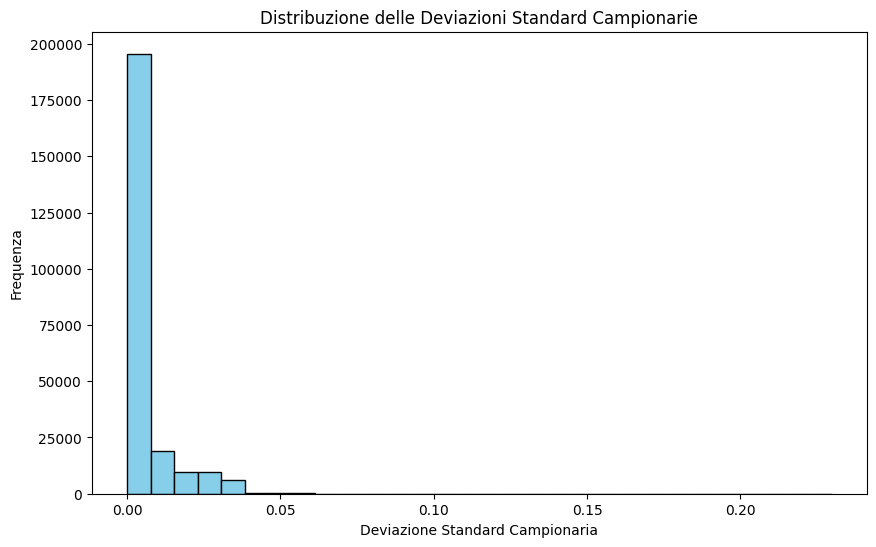

In [ ]:
# Calcoliamo la deviazione standard campionaria per ogni riga
dev_std = np.std(log_runs, axis=1)

# Vediamo la distribuzione delle deviazioni standard
import matplotlib.pyplot as plt

# Inizializziamo la figura
plt.figure(figsize=(10, 6))

# Plottiamo le deviazioni standard campionarie
plt.hist(dev_std,bins = 30, edgecolor='black',color='skyblue', linewidth=1)

# Aggiungi etichette e titolo al grafico
plt.xlabel('Deviazione Standard Campionaria')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Deviazioni Standard Campionarie')

In [ ]:
# Ordiniamo le deviazioni standard campionarie e vediamo i valori più alti
sorted(dev_std)[-10:-1]

[0.20420046772272776,
 0.20748704638973386,
 0.20960171557557147,
 0.21534811884582297,
 0.21568318150006607,
 0.21644042931507865,
 0.21771517899627366,
 0.22115904246365997,
 0.22862167768586933]

I valori più elevati del vettore delle deviazioni standard, come potevamo intuire dal grafico delle distribuzioni, sono dell'ordine di $10^{-1}$, quindi non ci sono valori sostanzialmente diversi da quelli delle altre osservazioni

## Calcoliamo la media dei tempi di esecuzione registrati ad ogni Run

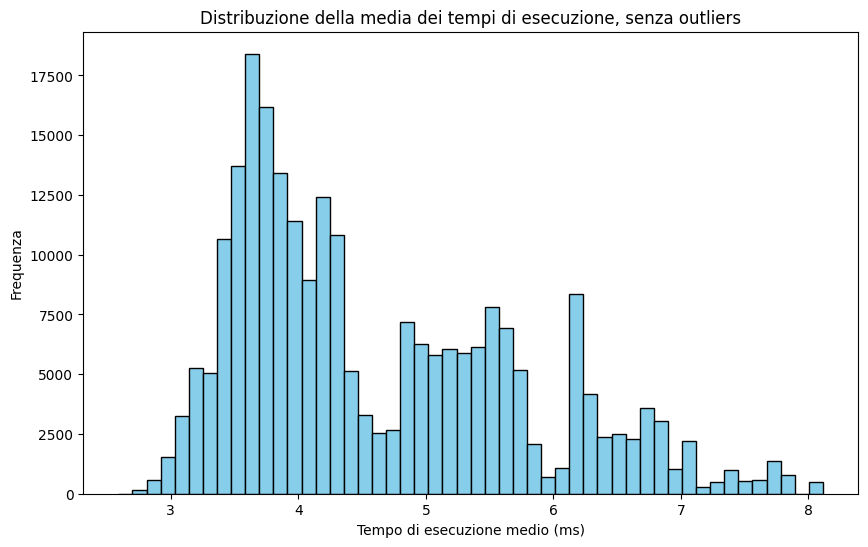

In [ ]:
# Medie dei tempi (logaritmici) di esecuzione
media = log_runs.mean(axis=1)

# Vediamo la distribuzione delle medie dei tempi di esecuzione
import matplotlib.pyplot as plt

# Inizializziamo la figura
plt.figure(figsize=(10, 6))

# Plottiamo la distribuzione delle medie dei tempi di esecuzione
plt.hist(media,bins=50,color='skyblue', edgecolor='black', linewidth=1)

# Aggiungiamo etichette e titolo al grafico
plt.title('Distribuzione delle medie dei tempi di esecuzione')
plt.xlabel('Tempo di esecuzione medio (ms)')
plt.ylabel('Frequenza')

# Mostriamo il grafico
plt.show()

## Prepariamo il dataset per il modello di machine learning

Definiamo innanzitutto tutte le possibili combinazioni di parametri e le variabili target

In [ ]:
# Possibili combinazioni di parametri
X = sgemm.drop(columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'])
X

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0


Per avere una scala di misurazione più lineare, applichiamo il logaritmo in base 2 ai parametri che possono assumere, come valori, le potenze di 2



In [ ]:
X_scaled = np.log2(X[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']])
X[['MWG','NWG','KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']] = X_scaled
X

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0,0,0,0
1,4.0,4.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0,0,0,1
2,4.0,4.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0,0,1,0
3,4.0,4.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0,0,1,1
4,4.0,4.0,4.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,7.0,7.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,1,0,1,1
241596,7.0,7.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,1,1,0,0
241597,7.0,7.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,1,1,0,1
241598,7.0,7.0,5.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,1,1,1,0


In [ ]:
# Come labels prendiamo le medie dei tempi di esecuzione (logaritmici)
y = media

## Train e test sets

In [ ]:
# Dividiamo il dataset in train e test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensioni
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((193280, 14), (48320, 14), (193280,), (48320,))

## Realizziamo il modello Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Inizializziamo il modello RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Addestriamo il modello
rf_regressor.fit(X_train, y_train)

# Facciamo le previsioni sui dati di test
y_pred = rf_regressor.predict(X_test)

## Accuratezza del modello

Per valutare l'accuratezza del modello sui dati di test utilizziamo il Mean Squared Error

In [ ]:
# Calcoliamo il MSE
import math
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

# Valore del MSE e della sua radice (essendo un errore quadratico)
print('MSE = ', mse)
print('Radice MSE = ', math.sqrt(mse))

MSE =  0.0007710681494881481
Radice MSE =  0.027768113898645475


Quindi, la percentuale di errore stimata per il modello, dopo la conversione della variabile target in scala logaritmica, è di circa il 2,78%. Si tratta di un tasso di errore molto basso, suggerendo che il modello predice i tempi di esecuzione (logaritmici) con un'elevata precisione.

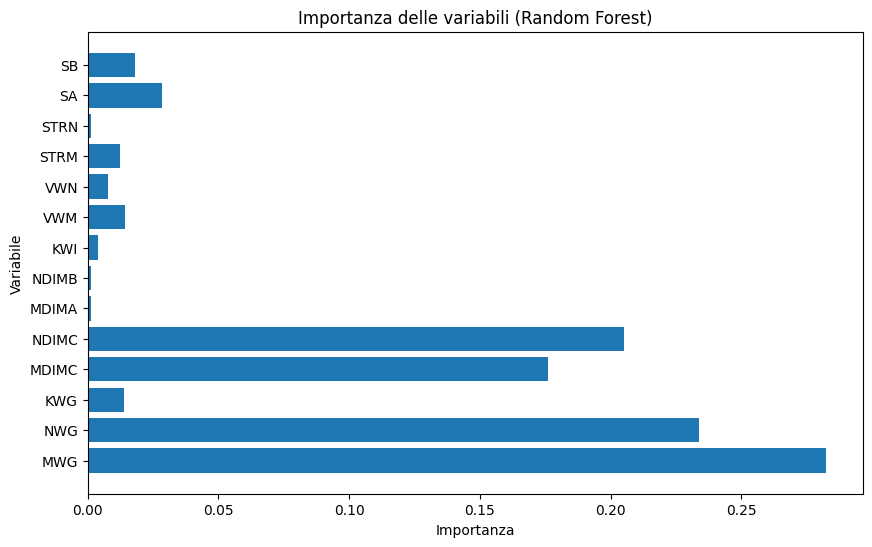

In [ ]:
# Calcoliamo l'importanza delle variabili
importanza_variabili = rf_regressor.feature_importances_
nomi_variabili = X.columns

# Visualizziamo l'importanza delle variabili
plt.figure(figsize=(10, 6))
plt.barh(nomi_variabili, importanza_variabili)
plt.xlabel('Importanza')
plt.ylabel('Variabile')
plt.title('Importanza delle variabili (Random Forest)')
plt.show()

Come possiamo notare dal grafico, l'importanza di una variabile è direttamente proporzionale alla lunghezza della barra azzura. Perciò possiamo concludere che:

*   MWG, NWG, MDIMC e NDIMC sono i parametri che più contribuiscono a determinare la performance predittiva del nostro modello Random Forest

*   STR, NDIMB e NDIMA, al contrario, risultano essere i parametri meno influenti nella determinazione dell'accuratezza predittiva del modello

